# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, I will identify lane lines on the road.  

**The tools I have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  **

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> My output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> My goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [5]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions.

In [27]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(extrapolate, vertices, img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    if (extrapolate == True):
        thickness = 10
      
        x_array_left = []
        y_array_left = []      
        x_array_right = []
        y_array_right = []
       
        aa_left = []
        bb_left = []
        aa_right = []
        bb_right = [] 
        
        for line in lines:
            for x1,y1,x2,y2 in line:
                
                slope = (y2-y1)/(x2-x1)
                
                if (slope < 0):
                    x_array_left.extend([x1,x2])
                    y_array_left.extend([y1,y2])
                    a,b = polyfit([x1,x2], [y1,y2], 1)
                    aa_left.append(a)
                    bb_left.append(b)                    
                else:
                    x_array_right.extend([x1,x2])
                    y_array_right.extend([y1,y2])             
                    a,b = polyfit([x1,x2], [y1,y2], 1)
                    aa_right.append(a)
                    bb_right.append(b)

        a1 = np.median(aa_left)
        b1 = np.median(bb_left)
        a2 = np.median(aa_right)
        b2 = np.median(bb_right)
        
        y_left_bottom = img.shape[0]
        x_left_bottom = int((img.shape[0] - b1)/a1)
        y_left_top = vertices[0,1][1]
        x_left_top = int((y_left_top - b1)/a1)
        
        y_right_bottom = img.shape[0]
        x_right_bottom = int((img.shape[0] - b2)/a2)
        y_right_top = vertices[0,2][1]
        x_right_top = int((y_right_top - b2)/a2)       

        # Checking whether extrapolate function has extreme points within region of interest
        if ((x_left_bottom - vertices[0,0][0] < 0) | (x_left_bottom - vertices[0,3][0] > 0)):
            x_left_bottom = vertices[0,0][0]
        if ((x_left_top - vertices[0,1][0] < 0) | (x_left_top - vertices[0,2][0] > 0)):
            x_left_top = vertices[0,1][0]
        if ((x_right_bottom - vertices[0,3][0] > 0) | (x_right_bottom - vertices[0,0][0] < 0)):
            x_right_bottom = vertices[0,3][0]
        if ((x_right_top - vertices[0,2][0] > 0) | (x_right_top - vertices[0,1][0] < 0)):
            x_right_top = vertices[0,2][0]      

        cv2.line(img, (x_left_bottom, y_left_bottom), (x_left_top, y_left_top), color, thickness)
        cv2.line(img, (x_right_bottom, y_right_bottom), (x_right_top, y_right_top), color, thickness)
        
    else:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, extrapolate, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(extrapolate, vertices, line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



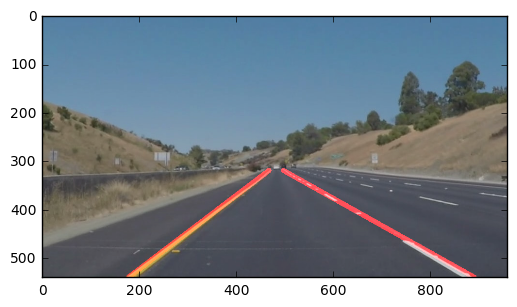

In [39]:
#reading in an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import polyval, polyfit

image = mpimg.imread('test_images/solidWhiteRight.jpg')
# image = mpimg.imread('test_images/solidWhiteCurve.jpg')
# image = mpimg.imread('test_images/solidYellowCurve.jpg')
# image = mpimg.imread('test_images/solidYellowCurve2.jpg')
# image = mpimg.imread('test_images/solidYellowLeft.jpg')
# image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

gray = grayscale(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)


# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)


# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(130,imshape[0]),(460, 320), (500,320), (890,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)


# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 10    # maximum gap in pixels between connectable line segments


# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments

# If extrapolate is set to False, there will be several lines on each side, instead of one per side
extrapolate = True
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, extrapolate, vertices)
result = weighted_img(lines, image)
plt.imshow(result, cmap='gray')

# plt.savefig('test_images/whiteCarLaneSwitch_solid_result.jpg')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def process_image(image):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import cv2

    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(130,imshape[0]),(460, 320), (500,320), (890,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 10    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    extrapolate = True
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, extrapolate, vertices)
    result = weighted_img(lines, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [28]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 36.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.03 s, sys: 859 ms, total: 3.89 s
Wall time: 6.96 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, I have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane ?  **

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [30]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:20<00:00, 33.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.2 s, sys: 2.7 s, total: 13 s
Wall time: 21.1 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))